# II: Low-Level Interactions

- The node interface is publicly available
- Nodes can be programmed directly in the host language
- Higher-order nodes can intefere with internal states

## Example: Reactive Probabilistic Programming

In [1]:
import numpy as np
import pyzls
from utils import plot_posterior, plot_pdf, animate_model

The interface for the probabilistic constructs is the following

In [2]:
%%zelus_lib -clear -name infer_importance

type 'a dist

val sample : 'a dist ~D~> 'a
val observe : 'a dist * 'a ~D~> unit

val infer : int -S-> ('a ~D~> 'b) -S-> 'a -D-> 'b dist

### Importance Sampling
- Probabilistic operators `sample` and `observe` are nodes
- `infer` is a higher-order node:
    - Launch n independent executions
    - At each step compute the score of each particles
    - Normalize to approximate the distribution

In [3]:
%%python_lib -clear -module infer_importance

from pyzls import CNode
import numpy as np

class Prob:
    def __init__(self, idx: int, scores):
        self.idx = idx
        self.scores = scores

class sample(CNode):
    def step(self, prob: Prob, d):
        return d.sample()

class observe(CNode):
    def step(self, prob: Prob, d, x):
        prob.scores[prob.idx] += d.log_prob(x)
        return ()
    
def infer(n: int):
    def infer(f: CNode):
        class infer(CNode):
            def __init__(self):
                self.scores = np.zeros(n)
                self.particles = [f() for _ in range(n)]
                self.idx = np.arange(n)

            def reset(self):
                self.scores = np.zeros(n)
                for p in self.particles:
                    p.reset()

            def step(self, *args):
                values = np.array(
                    [
                        p.step(Prob(i, self.scores), *args)
                        for i, p in enumerate(self.particles)
                    ]
                )
                probs = np.exp(self.scores) 
                probs /= np.sum(probs)
                return np.stack([values, probs], axis=1)
        return infer
    return infer

Let's try our first reactive probabilistic model: a kalman filter to track a position.

In [4]:
@pyzls.lib("dist")
def gaussian(*args: "'a") -> "'b":
    from torch.distributions import Normal
    return Normal(*args)

In [5]:
%%zelus -clear

open Dist
open Infer_importance

let proba kalman(x) = o where
     rec o = sample(gaussian(0. fby o, 2.))
     and _ = observe(gaussian(o, 4.), x)
     
let node tracker i = dist where
  rec dist = infer(100)(kalman)(i)

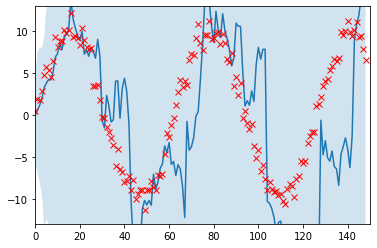

In [6]:
n = 150
noisy_sin = 10*np.sin(0.1*np.arange(n)) + np.random.randn(n)
animate_model(tracker(), noisy_sin)

Oupss

What happens here is that we always keep the same set of particles.  
The score keeps decreasing with each new observations.   
Eventually, all scores are so low that we get no informations.


### Particle Filtering

Same as before but during inference:
- At each step we resample the particles
- We duplicate particles with high score and discard particles with low scores

In [7]:
%%zelus_lib -c -name infer_pf

type 'a dist
val sample : 'a dist ~D~> 'a
val observe : 'a dist * 'a ~D~> unit

val infer : int -S-> ('a ~D~> 'b) -S-> 'a -D-> 'b dist

In [8]:
%%python_lib -clear -module infer_pf

from pyzls import CNode
import numpy as np

class Prob:
    def __init__(self, idx: int, scores):
        self.idx = idx
        self.scores = scores

class sample(CNode):
    def step(self, prob: Prob, d):
        return d.sample()

class observe(CNode):
    def step(self, prob: Prob, d, x):
        prob.scores[prob.idx] += d.log_prob(x)
        return ()

def infer(n: int):
    def infer(f: CNode):
        class infer(CNode):
            def __init__(self):
                self.scores = np.zeros(n)
                self.particles = [f() for _ in range(n)]

            def reset(self):
                self.scores.fill(0)
                for p in self.particles:
                    p.reset()

            def step(self, *args):
                values = np.array(
                    [
                        p.step(Prob(i, self.scores), *args)
                        for i, p in enumerate(self.particles)
                    ]
                )
                probs = np.exp(self.scores)
                probs /= np.sum(probs)
                ids = np.random.choice(n, size=n, p=probs)
                particles = [f() for _ in range(n)]
                for i, idx in enumerate(ids):
                    self.particles[idx].copy(particles[i])
                self.particles = particles
                self.scores.fill(0)
                return np.stack([values, probs], axis=1)
        return infer
    return infer

Let's try again!

In [9]:
%%zelus -clear

open Dist
open Infer_pf

let proba kalman(x) = o where
     rec o = sample(gaussian(0. fby o, 2.))
     and _ = observe(gaussian(o, 4), x)
     
let node tracker i = dist where
  rec dist = infer(100)(kalman)(i)

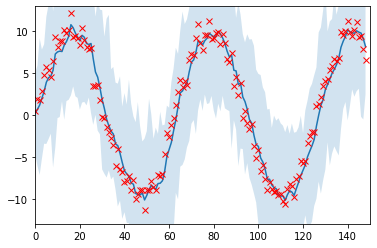

In [10]:
animate_model(tracker(), noisy_sin)